In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import random
from collections import Counter


import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

### 1. Understanding dataset


In [2]:
df = pd.read_csv("../../data/AMD Stock Price History.csv")
print(f"Dataset shape: {df.shape}")

Dataset shape: (1242, 7)


#### 1.2 Check for missing values & fill fix them

- think about possible reasons why data is missing


In [3]:
df.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

### 2 Summary Statistics & Data description

- identify features that are categorical, numerical, data/time
- generate summary statistics for numerical features to identify potential anomalies


In [4]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include='object').columns

print(f"Num of Numerical Features: {len(numerical_features)}")
print(f"Num of Categorical Features: {len(categorical_features)}")

print(f"Numerical features: {numerical_features}")
print(f"categorical features: {categorical_features}")

Num of Numerical Features: 4
Num of Categorical Features: 3
Numerical features: Index(['Price', 'Open', 'High', 'Low'], dtype='object')
categorical features: Index(['Date', 'Vol.', 'Change %'], dtype='object')


In [5]:
df.head(1)

,Date,Price,Open,High,Low,Vol.,Change %
0,12/06/2024,138.59,141.48,142.79,137.4,33.58M,-1.96%


### Data processing to convert Vol. & Change % to numerical


In [ ]:
def convert_volume(vol):
    if vol.endswith('M'):
        return float(vol[:-1]) * 1e6
    elif vol.endswith('K'):
        return float(vol[:-1]) * 1e3
    elif vol.endswith('B'):
        return float(vol[:-1]) * 1e9
    else:
        return float(vol)

df['Vol.'] = df['Vol.'].apply(convert_volume)

df['Change %'] = df['Change %'].str.rstrip('%').astype('float')

df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.               float64
Change %           float64
dtype: object

In [9]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include='object').columns

print(f"Num of Numerical Features: {len(numerical_features)}")
print(f"Num of Categorical Features: {len(categorical_features)}")

print(f"Numerical features: {numerical_features}")
print(f"categorical features: {categorical_features}")

Num of Numerical Features: 6
Num of Categorical Features: 0
Numerical features: Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')
categorical features: Index([], dtype='object')


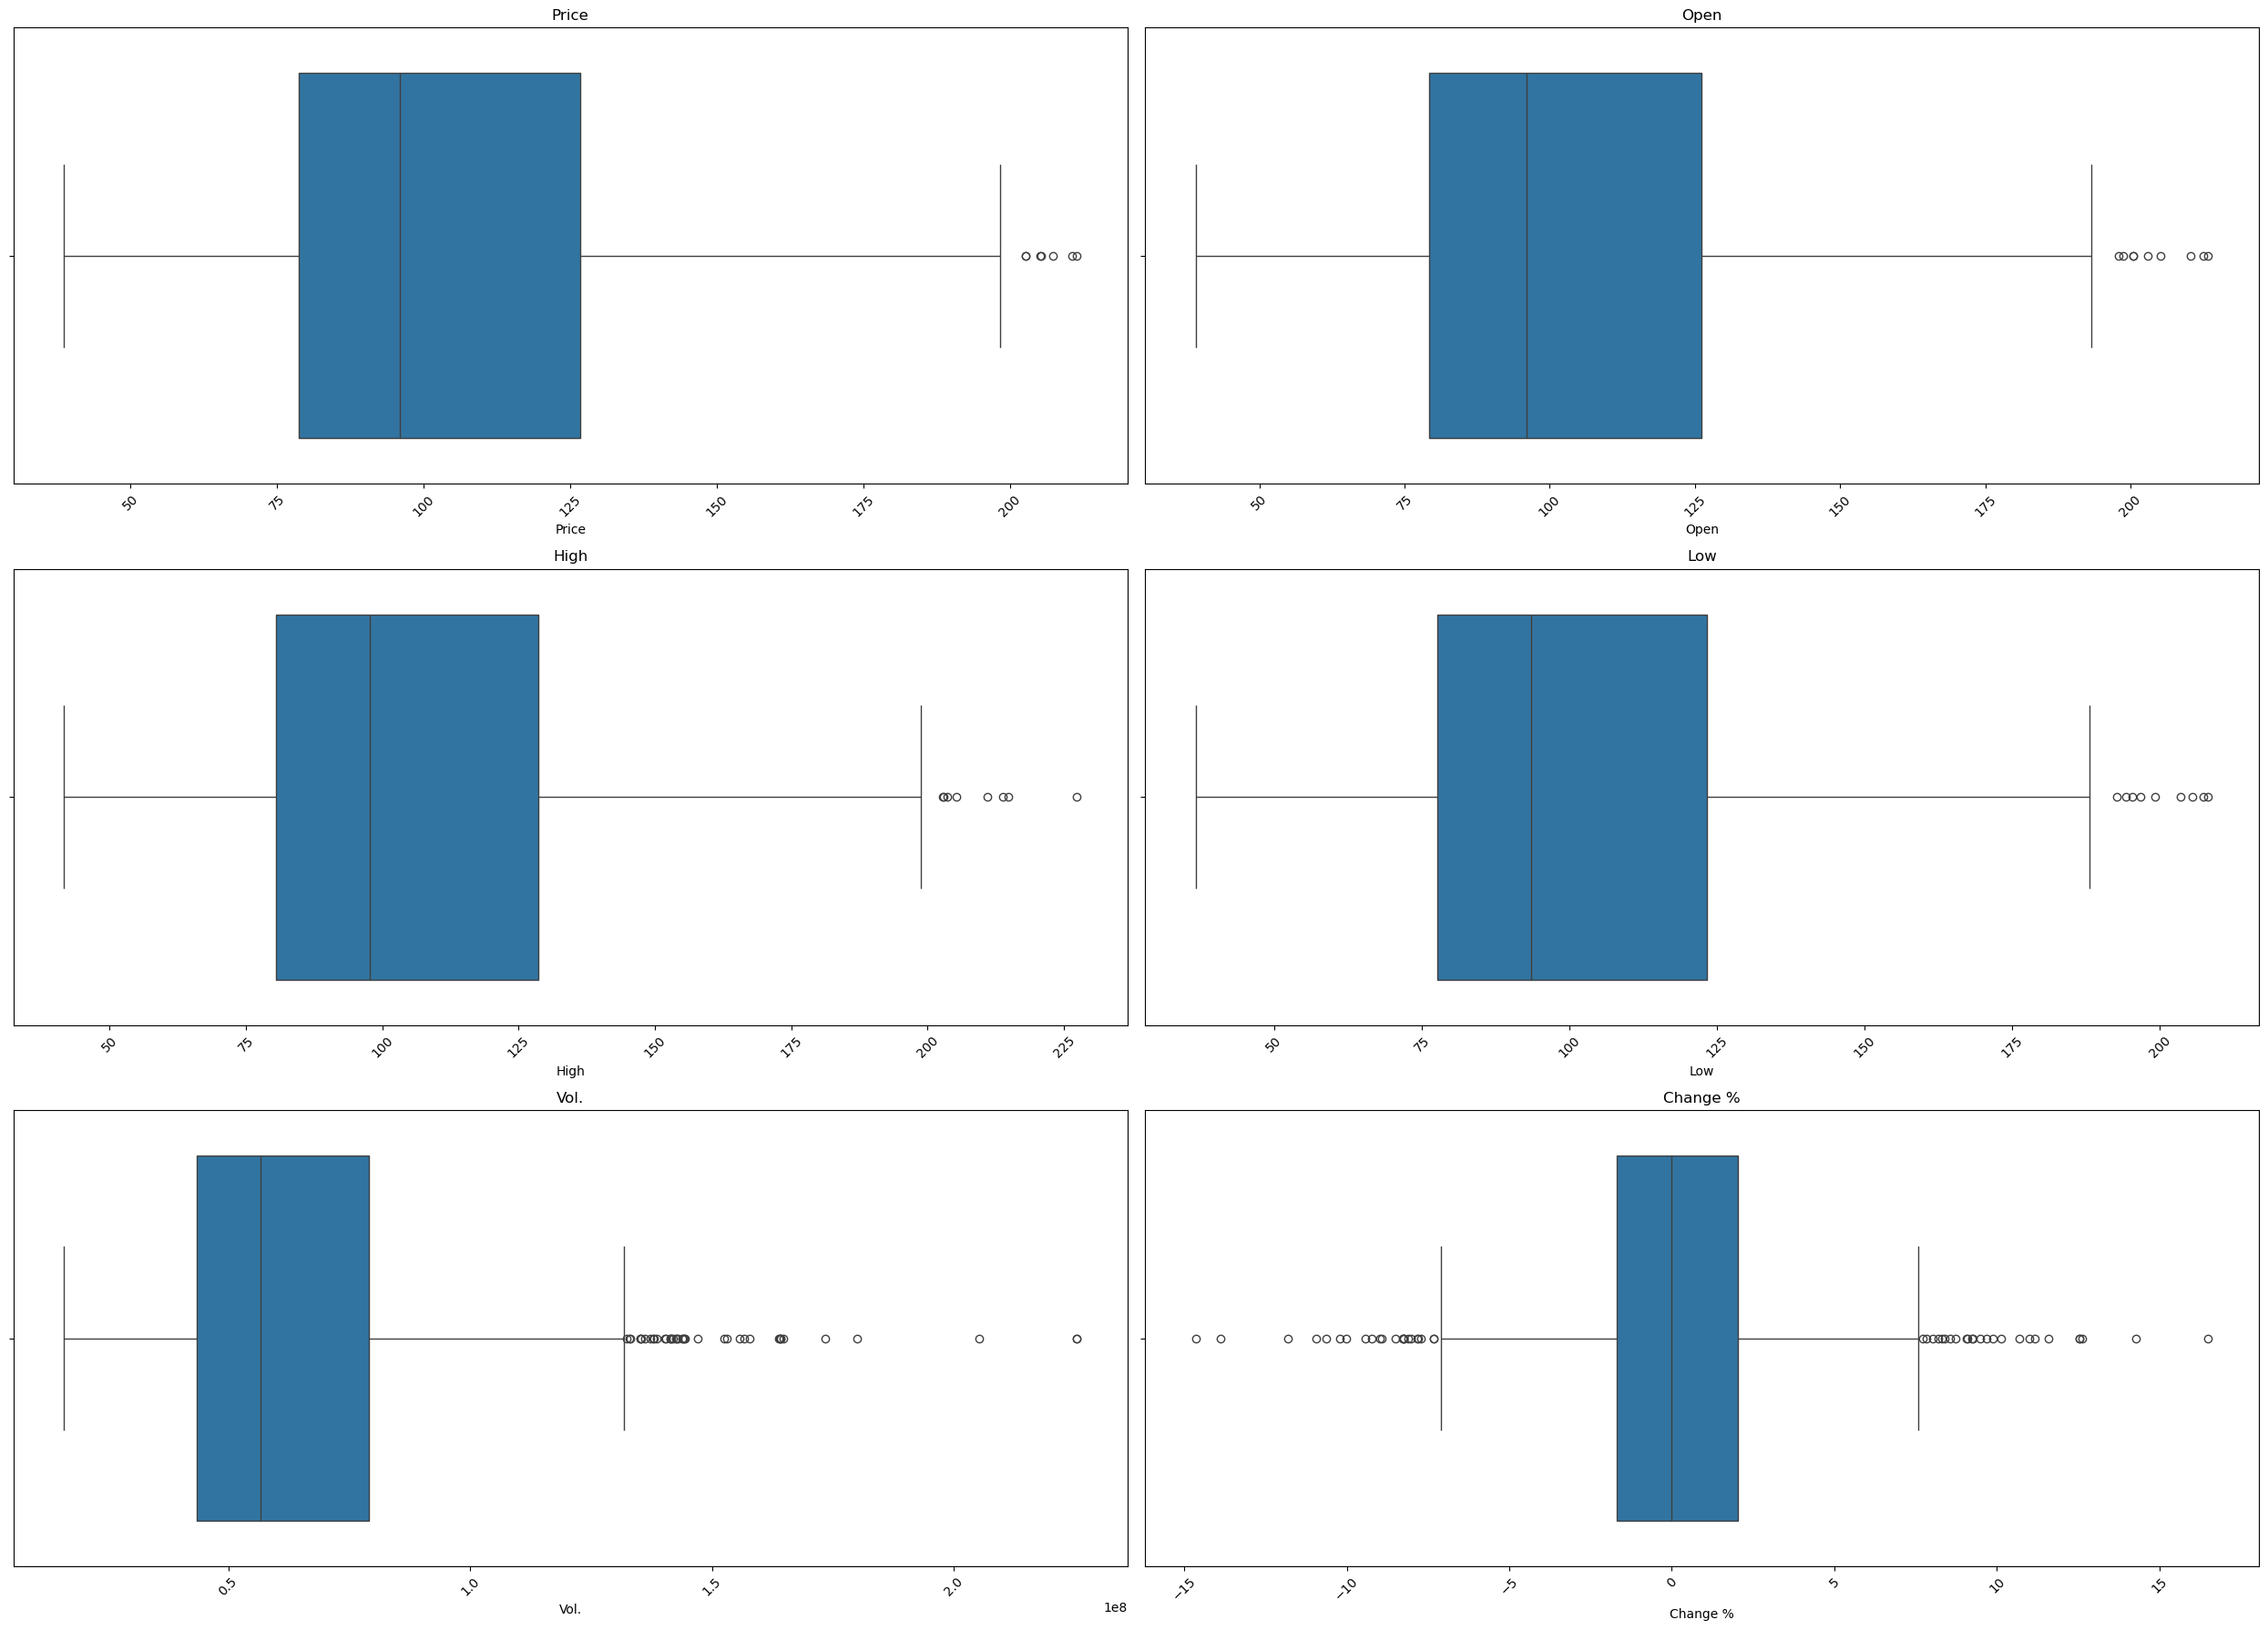

In [10]:
num_columns = 2
num_rows = len(numerical_features) // num_columns + (len(numerical_features) % num_columns != 0)  # To handle case when the number of columns isn't a multiple of 3

plt.figure(figsize=(25, 6 * num_rows))  # Adjust the height of the plot based on number of rows

# Create a box plot for each column
for i, col in enumerate(numerical_features):
    
    plt.subplot(num_rows, num_columns, i + 1)  # Adjust the grid size (num_rows, num_columns)
    sb.boxplot(data=df, x=col)
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
    



## Build Decision Tree Regressor


In [11]:
class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
    
    def _variance_reduction(self, y, left_indices, right_indices):
        total_var = np.var(y) * len(y)
        left_var = np.var(y[left_indices]) * len(left_indices) if len(left_indices) > 0 else 0
        right_var = np.var(y[right_indices]) * len(right_indices) if len(right_indices) > 0 else 0
        return total_var - (left_var + right_var)

    def _split(self, X, y, feature_index, threshold):
        left_indices = np.where(X[:, feature_index] <= threshold)[0]
        right_indices = np.where(X[:, feature_index] > threshold)[0]
        return left_indices, right_indices
    
    def _best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_variance_reduction = -float('inf')
        best_splits = None
        
        for feature_index in range(X.shape[1]):
            unique_feature_val = np.unique(X[:, feature_index]) 
            for val in unique_feature_val:
                left_indices, right_indices = self._split(X, y, feature_index, val)
                if len(left_indices) < self.min_samples_split or len(right_indices) < self.min_samples_split:
                    continue
                variance_reduction = self._variance_reduction(y, left_indices, right_indices)
                if variance_reduction > best_variance_reduction:
                    best_variance_reduction = variance_reduction
                    best_feature = feature_index
                    best_threshold = val
                    best_splits = (left_indices, right_indices)
    
        return best_feature, best_threshold, best_splits

    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(X) <= self.min_samples_split:
            return {'value': np.mean(y)} # leaf node

        feature, threshold, splits = self._best_split(X, y)
        
        if feature is None:
            return {'value': np.mean(y)} # leaf node
        
        left_indices, right_indices = splits
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
            
        return {
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }
        
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)
    
    def _predict_sample(self, x, tree):
        if 'value' in tree:
            return tree['value']

        if x[tree['feature']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])
    
    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])
        

### Prep the data using Kfold cross validation


In [12]:
X = df.drop('Price', axis = 1).values
y = df['Price'].values

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
errors = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
errors = []

model = CustomDecisionTreeRegressor(max_depth=3)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    error = np.mean((predictions - y_test) ** 2)
    errors.append(error)

print(f"Mean Squared Error across folds: {np.mean(errors)}")


Mean Squared Error across folds: 35.31031803136636


### Perform Prediction


In [20]:
df.drop('Price', axis=1).iloc[0].values

array([Timestamp('2024-12-06 00:00:00'), 141.48, 142.79, 137.4,
       33580000.0, -1.96], dtype=object)

In [21]:
predictions = []

feature_df = df.drop('Price', axis=1)

for i in range(len(feature_df)):
    row = feature_df.iloc[i].values
    pred_price = model.predict([row])
    predictions.append(pred_price[0])

In [22]:
predictions

[139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 158.26336283185842,
 158.26336283185842,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 139.9335294117647,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 180.71446808510638,
 180.71446808510638,
 180.71446808510638,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185842,
 158.26336283185

In [23]:
df['pred_Prices'] = predictions

In [25]:
df[['Price', 'pred_Prices']]

,Price,pred_Prices
0,138.59,139.933529
1,141.36,139.933529
2,143.99,139.933529
3,141.98,139.933529
4,142.06,139.933529
5,137.18,139.933529
6,136.24,139.933529
7,137.72,139.933529
8,141.13,139.933529
9,138.35,139.933529


### AMD data unseen by model


In [27]:
unseen_df = pd.read_csv("../../data/AMD Stock Price History Unseen.csv")

In [28]:
unseen_df['Vol.'] = unseen_df['Vol.'].apply(convert_volume)

unseen_df['Change %'] = unseen_df['Change %'].str.rstrip('%').astype('float')

unseen_df['Date'] = pd.to_datetime(unseen_df['Date'])

In [29]:
unseen_df_features = unseen_df.drop('Price', axis=1)


In [33]:
unseen_pred = []
for i in range(len(unseen_df_features)):
    sample = unseen_df_features.iloc[i]
    pred = model.predict([sample])
    unseen_pred.append(pred[0])

/var/folders/fc/n6ycqzwx13989g40ry2djdsh0000gn/T/ipykernel_35871/2822340942.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[tree['feature']] <= tree['threshold']:


In [34]:
unseen_df['Predicted_Price'] = unseen_pred

In [35]:
unseen_df[['Price', 'Predicted_Price']]

,Price,Predicted_Price
0,23.09,52.073871
1,19.25,52.073871
2,20.18,52.073871
3,21.93,52.073871
4,20.85,52.073871
5,19.80,52.073871
6,19.76,52.073871
7,20.77,52.073871
8,20.25,52.073871
9,19.73,52.073871


In [36]:
len(predictions)

1242

In [38]:
set(predictions)

{52.07387096774194,
 73.44415254237288,
 88.10335766423357,
 107.4423163841808,
 121.33392857142857,
 139.9335294117647,
 158.26336283185842,
 180.71446808510638}